In [1]:
import os
import random
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print("Using ",device)    

Using  cuda


In [3]:
train_data_dir = "./data/omniglot/train"
test_data_dir = "./data/omniglot/test"

In [4]:
class Omniglot(datasets.ImageFolder):
    def __init__(self,root_dir,train=True,transform=None):
        if (train == True):
            self.data_dir = root_dir + "/train"
        else:
            self.data_dir = root_dir + "/test"
            
        super().__init__(root=self.data_dir,transform=transform)
    
    def find_classes(self, directory):
        alphabets = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        classes = []
        for alphabet in alphabets:
            alphabet_dir = os.path.join(directory,alphabet)
            characters = sorted(entry.name for entry in os.scandir(alphabet_dir) if entry.is_dir())
            characters = [alphabet +"/"+ chr for chr in characters]
            classes += characters

        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        
        return classes, class_to_idx
    
    def get_batch(self,Nc,Ns,Nq):
        unique_targets = list(np.unique(self.targets))
        picked_classes = random.sample(unique_targets,Nc)
        all_support_samples = []
        all_query_samples = []
        support_targets = []
        query_targets = []
        for pc in picked_classes:
            picked_samples = [s[0] for s in self.samples if s[1] == pc]
            
            support_samples =  random.sample(picked_samples,Ns)
            all_support_samples.append([self.get_item_from_path(ss) for ss in support_samples])
            support_targets.append([pc]*Ns)
            
            remaining_samples = [rs for rs in picked_samples if rs not in support_samples]
            
            query_samples = random.sample(remaining_samples,Nq)
            all_query_samples.append([self.get_item_from_path(qs) for qs in query_samples])
            query_targets.append([pc]*Nq)
        
        return {
            "support" : (torch.stack([torch.stack(row) for row in all_support_samples]),
                         torch.tensor(support_targets)),
            "query" : (torch.stack([torch.stack(row) for row in all_query_samples]),
                         torch.tensor(query_targets)),
            }
        
    def get_item_from_path(self,path):
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample
        

In [5]:
train_ds = Omniglot(root_dir="data/omniglot",train=True,transform=ToTensor())
test_ds = Omniglot(root_dir="data/omniglot",train=False,transform=ToTensor())

In [6]:
batch  = train_ds.get_batch(5,5,1)
print(batch["support"][0].shape)

torch.Size([5, 5, 3, 105, 105])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_channels,out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,3),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    
    return conv

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_block(3,64)
        self.conv2 = conv_block(64,64)
        self.conv3 = conv_block(64,64)
        self.conv4 = conv_block(64,64)
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1024,64)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.flatten(x)
        x = self.linear1(x)
        
        return x

In [8]:
my_model = Net()
my_model = my_model.to(device)

In [9]:
import torch.optim as optim
optimizer = optim.Adam(my_model.parameters(), lr=0.001)

In [10]:
def calc_loss(dist_matrix):  
    Nc,N = dist_matrix.shape
    Nq = int(N/Nc)
    
    sum_dist = torch.sum(dist_matrix,dim=0)
    prob = torch.log(torch.divide(dist_matrix,sum_dist))
    prob = torch.reshape(prob,(Nc,Nc,Nq))
    loss = -1*torch.mean(torch.diagonal(prob,dim1=0,dim2=1))
    
    return loss

In [11]:
def calc_acc(dist_matrix): 
    Nc,N = dist_matrix.shape
    Nq = int(N/Nc)
       
    true_vals = torch.arange(0,Nc)
    true_vals = true_vals.repeat_interleave(Nq)
    true_vals = true_vals.to(device)
    pred = torch.argmax(dist_matrix,dim=0)
    acc = torch.sum(pred==true_vals)/(Nc*Nq)
    
    return acc

In [12]:
def train(num_episodes,Nc,Ns,Nq):
    for episode in range(num_episodes):
        batch_data = train_ds.get_batch(Nc,Ns,Nq)
        support_data = batch_data["support"][0]
        _,_,in_C,H,W = support_data.shape
        
        support_data = support_data.to(device)
        
        optimizer.zero_grad()
        
        support_embeddings = my_model(torch.reshape(support_data,(Nc*Ns,in_C,H,W)))
        _,out_C = support_embeddings.shape
        support_embeddings = torch.reshape(support_embeddings,(Nc,Ns,out_C))
        prototypes = torch.mean(support_embeddings,dim=1)
        
        query_data = batch_data["query"][0]
        query_data = query_data.to(device)
        
        query_embeddings = my_model(torch.reshape(query_data,(Nc*Nq,in_C,H,W)))
        
        prototypes = torch.unsqueeze(prototypes,0)
        all_query = torch.unsqueeze(query_embeddings,0)

        dist_matrix = torch.exp(-1*torch.squeeze(torch.cdist(prototypes,all_query,p=2)))
        
        loss = calc_loss(dist_matrix)
        acc = calc_acc(dist_matrix)
        
        loss.backward()
        optimizer.step()
        
        if (episode % 50 == 0):
            print("Episode = ",episode + 1)
            print("Loss = ",loss.item())
            print("Accuracy = ",acc.item()*100)

In [13]:
def test(num_episodes,Nc,Ns,Nq):
    with torch.no_grad():
        running_loss = 0
        running_acc = 0.0
        my_model.eval()
        for episode in range(num_episodes):
            batch_data = test_ds.get_batch(Nc,Ns,Nq)
            support_data = batch_data["support"][0]
            _,_,in_C,H,W = support_data.shape
            
            support_data = support_data.to(device)
            
            support_embeddings = my_model(torch.reshape(support_data,(Nc*Ns,in_C,H,W)))
            _,out_C = support_embeddings.shape
            support_embeddings = torch.reshape(support_embeddings,(Nc,Ns,out_C))
            prototypes = torch.mean(support_embeddings,dim=1)
            
            query_data = batch_data["query"][0]
            query_data = query_data.to(device)
            
            query_embeddings = my_model(torch.reshape(query_data,(Nc*Nq,in_C,H,W)))
            prototypes = torch.unsqueeze(prototypes,0)
            all_query = torch.unsqueeze(query_embeddings,0)
        
            dist_matrix = torch.exp(-1*torch.squeeze(torch.cdist(prototypes,all_query,p=2)))
            
            loss = calc_loss(dist_matrix)
            acc = calc_acc(dist_matrix)
            
            running_loss += loss.item()
            running_acc += acc.item()
            
            if (episode % 50 == 49):
                print("Episode = ",episode+1)
                print("Running Loss = ",running_loss/(episode+1))
                print("Running Accuracy = ",running_acc*100/((episode+1)))

In [14]:
train(500,60,5,5)

Episode =  1
Loss =  3.4850406646728516
Accuracy =  41.66666865348816
Episode =  51
Loss =  0.52754807472229
Accuracy =  85.00000238418579
Episode =  101
Loss =  0.3287772834300995
Accuracy =  90.00000357627869
Episode =  151
Loss =  0.2181118130683899
Accuracy =  92.66666769981384
Episode =  201
Loss =  0.19667868316173553
Accuracy =  93.00000071525574
Episode =  251
Loss =  0.2035631388425827
Accuracy =  93.99999976158142
Episode =  301
Loss =  0.2210637778043747
Accuracy =  92.33333468437195
Episode =  351
Loss =  0.17340050637722015
Accuracy =  94.66667175292969
Episode =  401
Loss =  0.12526540458202362
Accuracy =  97.00000286102295
Episode =  451
Loss =  0.07841687649488449
Accuracy =  98.66666793823242


In [15]:
test(500,20,5,5)

Episode =  50
Running Loss =  0.11855718076229095
Running Accuracy =  96.45999753475189
Episode =  100
Running Loss =  0.1222271459363401
Running Accuracy =  96.24999749660492
Episode =  150
Running Loss =  0.12533172776922583
Running Accuracy =  96.1999975045522
Episode =  200
Running Loss =  0.12641027564182877
Running Accuracy =  96.1149974167347
Episode =  250
Running Loss =  0.1271176483258605
Running Accuracy =  96.0999974489212
Episode =  300
Running Loss =  0.12369275968521834
Running Accuracy =  96.1833307147026
Episode =  350
Running Loss =  0.12177459204835551
Running Accuracy =  96.22856880937304
Episode =  400
Running Loss =  0.12237286294344812
Running Accuracy =  96.19999738037586
Episode =  450
Running Loss =  0.12296191931184795
Running Accuracy =  96.15777519014146
Episode =  500
Running Loss =  0.12464963607117534
Running Accuracy =  96.12599741220474


In [16]:
torch.save(my_model.state_dict(), "model.pth")

In [37]:
def get_predictions(dist_matrix):
    Nc=5
    Ns=5
    Nq=5 
    Nc,N = dist_matrix.shape
    Nq = int(N/Nc)
       
    true_vals = torch.arange(0,Nc)
    true_vals = true_vals.repeat_interleave(Nq)
    true_vals = true_vals.to(device)
    pred = torch.argmax(dist_matrix,dim=0)
    
    return pred

In [55]:
def predict(batch_data,r_perm):
    Nc=5
    Ns=5
    Nq=5
    with torch.no_grad():
        my_model.eval()
        support_data = batch_data["support"][0]
        _,_,in_C,H,W = support_data.shape
        
        support_data = support_data.to(device)
        
        support_embeddings = my_model(torch.reshape(support_data,(Nc*Ns,in_C,H,W)))
        _,out_C = support_embeddings.shape
        support_embeddings = torch.reshape(support_embeddings,(Nc,Ns,out_C))
        prototypes = torch.mean(support_embeddings,dim=1)
        
        query_data = batch_data["query"][0]
        _,_,C,H,W = query_data.shape
        query_data = torch.reshape(query_data,(25,C,H,W))
        
        query_data = query_data[r_perm]
        query_data = query_data.to(device)
        
        query_embeddings = my_model(torch.reshape(query_data,(Nc*Nq,in_C,H,W)))
        prototypes = torch.unsqueeze(prototypes,0)
        all_query = torch.unsqueeze(query_embeddings,0)
    
        dist_matrix = torch.exp(-1*torch.squeeze(torch.cdist(prototypes,all_query,p=2)))
        pred = get_predictions(dist_matrix)
        return pred

In [69]:
example_batch = test_ds.get_batch(5,5,5)
eg_support = example_batch["support"][0].permute(0,1,3,4,2)
eg_query = example_batch["query"][0].permute(0,1,3,4,2)
_,_,C,H,W = eg_query.shape
eg_query = torch.reshape(eg_query,(25,C,H,W))
r_perm = torch.randperm(25)
eg_query = eg_query[r_perm]
eg_query = eg_query.reshape((5,5,C,H,W))

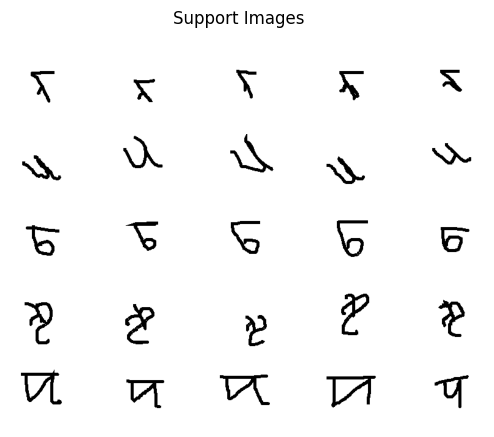

In [70]:
fig, ax = plt.subplots(5,5)
fig.suptitle('Support Images')
for i in range(5):
    for j in range(5):
        img_tensor = eg_support[i][j]
        np_img = img_tensor.detach().cpu().numpy()
        ax[i,j].set_axis_off()
        ax[i,j].imshow(np_img)
        

In [71]:
predictions = predict(example_batch,r_perm).reshape((5,5)).detach().cpu().numpy()

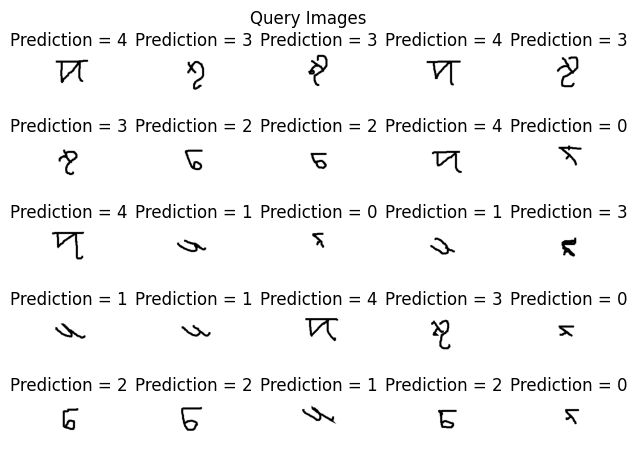

In [74]:
fig, ax = plt.subplots(5,5)
fig.suptitle('Query Images')
fig.tight_layout()
for i in range(5):
    for j in range(5):
        img_tensor = eg_query[i][j]
        np_img = img_tensor.detach().cpu().numpy()
        ax[i,j].set_axis_off()
        ax[i,j].imshow(np_img)
        ax[i,j].set_title("Prediction = "+str(predictions[i][j]))